In [1]:
from scipy import fft
from scipy import signal as sig
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.simplefilter('ignore')

In [2]:
# Read & prep data
df = pd.read_csv('../data/PA_911_calls.csv')
df = df.rename(columns = {k:k.lower() for k in df.columns})
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp_trunc'] = df['timestamp'].dt.floor('H')
df['N'] = 1

# Count calls per hour
counts = df.groupby(['timestamp_trunc']).sum()
counts = counts[['N']]
counts_dict = counts['N'].to_dict()

In [3]:
# Create a new DF with time & signal, filling in missing hours with 0 calls
data = pd.DataFrame()
data['time'] = pd.date_range(min(counts.index), max(counts.index), freq = 'H')
data.set_index('time')
data['time_sec'] = (data.time - min(data.time)).dt.total_seconds()
data['signal'] = data.time.apply(lambda x: counts_dict[x] if x in counts_dict.keys() else 0)

# time_sec is the hourly timestamp converted to seconds
X = pd.DataFrame(data['time_sec']) 
# signal is how many calls were made in that hour
y = pd.DataFrame(data['signal']) 

model = LinearRegression()
model.fit(X, y) 
data['pred_signal_linreg'] = model.predict(X)
data['residuals'] = data['signal'] - data['pred_signal_linreg']

time = data['time']
residuals = data['residuals']

In [4]:
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model.coef_[0,0], model.intercept_[0]))
print('R-squared: {:.2e}'.format(model.score(X,y)))

Slope: -2.59e-10, Intercept: 16.40
R-squared: 1.00e-06


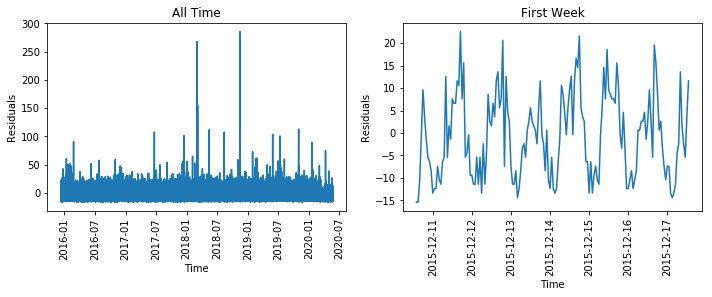

In [5]:
## Plot residuals in the time domain
plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(time, residuals, label='residuals')
ax1.set_title('All Time')
ax1.set_ylabel( 'Residuals' )
ax1.set_xlabel( 'Time' )
plt.xticks(rotation=90)

N = 24 * 7

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(time[:N], residuals[:N])
ax2.set_title('First Week')
ax2.set_ylabel( 'Residuals' )
ax2.set_xlabel( 'Time' )

plt.tight_layout()
plt.xticks(rotation=90)

plt.show()

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ]),
 <a list of 8 Text xticklabel objects>)

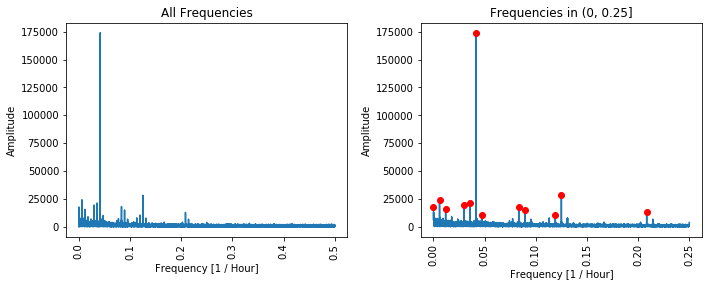

In [6]:
# Plotting power in the frequency domain
fft_output = fft.fft(residuals)
power = np.abs(fft_output)
freq = fft.fftfreq(len(residuals))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='residuals')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Hour]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.25)
ax2.plot(freq[mask], power[mask])
ax2.set_title('Frequencies in (0, 0.25]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Hour]' )

peaks = sig.find_peaks(power[freq >=0], prominence=10**4)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()
plt.xticks(rotation=90)

In [7]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/hour)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq / 24
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output

,index,freq (1/hour),amplitude,period (days),fft
5,1626,0.041673,174062.084528,0.999846,(120273.04896310496-125825.28745533973j)
10,4877,0.124994,28318.255106,0.333350,(9525.639377946429-26668.06642207509j)
1,232,0.005946,24289.772503,7.007543,(7808.147856310054+23000.56250003811j)
4,1394,0.035727,21381.738600,1.166248,(-8264.48419317551-19719.965684564075j)
3,1161,0.029755,19584.401875,1.400301,(-17130.139808699645+9492.47633382274j)
7,3251,0.083321,18170.792475,0.500077,(-1690.5495210599192-18091.980031949737j)
0,1,0.000026,17780.855851,1625.750000,(-14079.85465480642+10858.937687870535j)
2,465,0.011918,15654.936021,3.496237,(-15141.130185396498+3977.8384235142676j)
8,3484,0.089292,15089.614901,0.466633,(-3782.246915055045-14607.911764648146j)
11,8129,0.208340,12878.130056,0.199994,(-1115.8299918725634+12829.698249689924j)


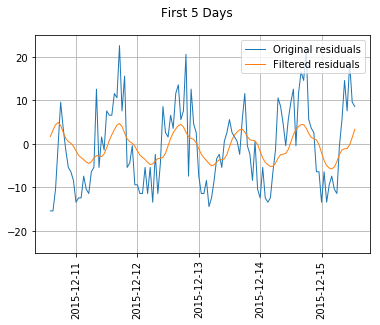

In [8]:
filtered_fft_output = np.array([f if i in list(output['index']) else 0 for i, f in enumerate(fft_output)])
filtered_residuals = fft.ifft(filtered_fft_output)

N = 24 * 5
plt.plot(time[:N], residuals[:N], linewidth=1, label='Original residuals')
plt.plot(time[:N], filtered_residuals[:N].real, linewidth=1, label='Filtered residuals')
plt.legend(loc='upper right')
plt.suptitle('First 5 Days')
plt.grid()
plt.ylim((-25, 25))
plt.xticks(rotation=90)

print()

In [9]:
from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = output['fft']
fourier_terms['freq (1 / hour)'] = output['freq (1/hour)']
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms.sort_values(by=['amplitude'], ascending=[0])

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms

,fft,freq (1 / hour),amplitude,phase
label,,,,
FT_1,(120273.04896310496-125825.28745533973j),0.041673,174062.084528,-0.807955
FT_2,(9525.639377946429-26668.06642207509j),0.124994,28318.255106,-1.227728
FT_3,(7808.147856310054+23000.56250003811j),0.005946,24289.772503,1.243527
FT_4,(-8264.48419317551-19719.965684564075j),0.035727,21381.738600,-1.967652
FT_5,(-17130.139808699645+9492.47633382274j),0.029755,19584.401875,2.635577
FT_6,(-1690.5495210599192-18091.980031949737j),0.083321,18170.792475,-1.663968
FT_7,(-14079.85465480642+10858.937687870535j),0.000026,17780.855851,2.484636
FT_8,(-15141.130185396498+3977.8384235142676j),0.011918,15654.936021,2.884681
FT_9,(-3782.246915055045-14607.911764648146j),0.089292,15089.614901,-1.824150


In [10]:
for key in fourier_terms_dict.keys():
    a = fourier_terms_dict[key]['amplitude']
    w = 2 * math.pi * (fourier_terms_dict[key]['freq (1 / hour)'] / 3600)
    p = fourier_terms_dict[key]['phase']
    data[key] = data['time_sec'].apply(lambda t: a * math.cos(w*t + p))

data['FT_All'] = 0
for column in list(fourier_terms.index):
    data['FT_All'] = data['FT_All'] + data[column]


# Sample 
data[['signal', 'time_sec', 'FT_All']  + list(fourier_terms.index)]



,signal,time_sec,FT_All,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6,FT_7,FT_8,FT_9,FT_10,FT_11,FT_12
0,1,0.0,67514.151651,120273.048963,9525.639378,7808.147856,-8264.484193,-17130.139809,-1690.549521,-14079.854655,-15141.130185,-3782.246915,-1115.829992,-8794.255138,-94.194139
1,1,3600.0,123452.858342,148744.464534,25592.326795,6943.606218,-3667.475081,-18596.015296,7580.601560,-14081.603119,-15396.284984,4569.936595,-12681.425215,-2445.375106,-3109.898558
2,6,7200.0,172119.966092,167076.090710,26668.833307,6069.374211,1113.567986,-19413.780855,14821.146895,-14083.351219,-15565.152133,11521.002953,-5447.572460,5209.081541,-5849.274843
3,16,10800.0,192788.331529,174018.275416,12124.617286,5186.671899,5838.732195,-19554.935651,18091.571153,-14085.098953,-15646.785226,14939.793859,9861.977887,10082.429054,-8068.917390
4,26,14400.0,166248.839629,169097.775557,-9521.344816,4296.731164,10270.908734,-19014.560145,16515.830099,-14086.846322,-15640.726754,13778.127029,10551.740860,9572.805440,-9571.601216
5,20,18000.0,105436.890131,152650.017613,-25590.374332,3400.793990,14187.690917,-17811.487550,10516.015411,-14088.593326,-15547.010672,8392.163055,-4400.815544,3952.296839,-10223.806270
6,15,21600.0,49131.521213,125796.231891,-26670.366557,2500.110731,17392.534554,-15987.647456,1699.289541,-14090.339965,-15366.162206,433.208546,-12829.428347,-3778.328248,-9967.581270
7,11,25200.0,20973.167756,90367.019164,-12128.738181,1595.938365,19724.620543,-13606.604495,-7572.622779,-14092.086238,-15099.194912,-7658.565295,-2239.187456,-9491.718028,-8825.692932
8,10,28800.0,6873.356928,48777.560102,9517.050007,689.538736,21066.924775,-10751.342982,-14816.066619,-14093.832145,-14747.604994,-13402.265596,11670.513778,-10137.515087,-6899.603047
9,8,32400.0,-19924.310257,3862.974365,25588.421205,-217.823200,21352.090402,-7521.374736,-18090.750228,-14095.577687,-14313.362919,-15036.905778,8279.382264,-5370.930792,-4360.453152


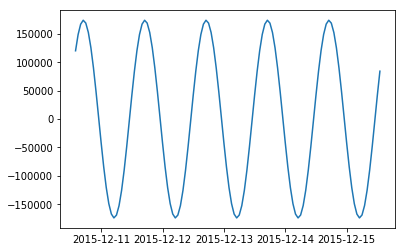

In [11]:
# Check the first Fourier term, which should have a period = 1 day
plt.plot(data['time'][:24*5], data['FT_1'][:24*5])


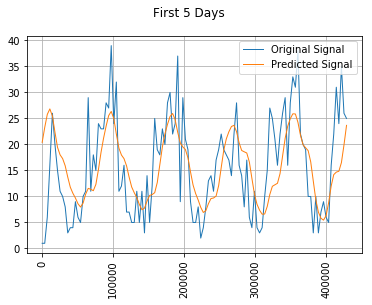

In [18]:
# time_sec is the hourly timestamp converted to seconds
# list(fourier_terms.index) are the names of our Fourier terms
# X = pd.DataFrame(data[['time_sec'] + list(fourier_terms.index)]) 
X = pd.DataFrame(data[['time_sec', 'FT_All']]) 
# signal is how many calls were made in that hour
y = pd.DataFrame(data['signal']) 

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)


N = 24 * 5

plt.plot(X['time_sec'][:N], y[:N], linewidth=1, label='Original Signal')
plt.plot(X['time_sec'][:N], y_pred[:N], linewidth=1, label='Predicted Signal')
plt.legend(loc='upper right')
plt.suptitle('First 5 Days')
plt.grid()
plt.xticks(rotation=90)

print()

In [13]:
model.score(X,y)

0.4089566840099922